First, the requirements are installed, the code of SAP-KG is imported, and some reoccurring variables are set:

In [1]:
pip install --no-cache-dir -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.5/347.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 8.0.3
    Uninstalling jupyter_client-8.0.3:
      Successfully uninstalled jupyter_client-8.0.3
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter_server 2.4.0
    Uninstalling jupyter_server-2.4.0:
      Successfully uninstalled jupyter_server-2.4.0

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import operator
import itertools
from SPARQLWrapper import SPARQLWrapper, JSON
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import Metric
import ipywidgets as widgets
from IPython.display import clear_output

from ipywidgets import GridspecLayout
import warnings

KGDBpedia = 'https://dbpedia.org/sparql'
KGWikidata = 'https://query.wikidata.org/sparql'

In [2]:
class Predicate():
    def construct(self, dict_pre_label):
        self.pre_label = dict_pre_label
    
    def __init__(self):
        self.pre_label = dict()

predicate = Predicate()

In [3]:
df_pre = pd.read_csv('Predicates.csv')
predicate_list = list(df_pre.Label.unique())
dict_predicate_label = dict(zip(df_pre.Label, df_pre.Predicate))
print(dict_predicate_label)
predicate.construct(dict_predicate_label)

{'cause of death': 'wdt:P509', 'manner of death': 'wdt:P1196', 'parent': 'wdt:P8810', 'father': 'wdt:P22', 'place of birth': 'wdt:P19', 'category for people born here': 'wdt:P1464', 'child': 'wdt:P40', 'relative': 'wdt:P1038', 'dbp:birthPlace': 'http://dbpedia.org/property/birthPlace', 'dbp:deathCause': 'http://dbpedia.org/property/deathCause', 'dbo:mother': 'http://dbpedia.org/ontology/mother', 'dbo:father': 'http://dbpedia.org/ontology/father', 'dbo:relative': 'http://dbpedia.org/ontology/relative', 'dbo:child': 'http://dbpedia.org/ontology/child'}


In [4]:
predicate_dropdown = widgets.Combobox(
    #value='',
    placeholder='Select the first predicate',
    options=predicate_list,
    description='Predicate 1:',
    ensure_option=True,
    disabled=False
)

predicate_dropdown2 = widgets.Combobox(
    #value='',
    placeholder='Select the second predicate',
    options=predicate_list,
    description='Predicate 2:',
    ensure_option=True,
    disabled=False
)

button_addPredicate = widgets.Button(description="Add First Predicate")
button_addPredicate2 = widgets.Button(description="Add Second Predicate")

button_restart = widgets.Button(
    description='Restart Predicates',
    disabled=False,
    button_style='danger',
    tooltip='Click me'
)

button_pos = widgets.Button(
    description='Compute POS value',
    disabled=False,
    button_style='success',
    tooltip='Click me'
)


output = widgets.Output()

grid = GridspecLayout(3, 3, height='150px')
grid[0, 0] = predicate_dropdown 
grid[0, 1] = button_addPredicate
grid[0, 2] = widgets.Text(value='', disabled=True)

grid[1, 0] = predicate_dropdown2 
grid[1, 1] = button_addPredicate2
grid[1, 2] = widgets.Text(value='', disabled=True)

grid[2, 0] = button_restart
grid[2, 2] = button_pos

display(grid)

def button_pre1_clicked(parm):    
    grid[0, 2:].value += predicate.pre_label[grid[0, 0].value]

def button_pre2_clicked(parm):    
    grid[1, 2:].value += predicate.pre_label[grid[1, 0].value]
    
def button_restart_clicked(parm):
    grid[0, 0].value = ''
    grid[0, 2:].value = ''
    grid[1, 0].value = ''
    grid[1, 2:].value = ''
    
def button_compute_pos(parm):
    with output:
        predicate1 = grid[0, 2].value
        predicate2 = grid[1, 2].value
        input_data = {"Input":{"IndependentVariables":{"WikidataPredicate":[], "WikidataPredicate2":[]}}}
        input_data["Input"]["IndependentVariables"]["WikidataPredicate2"] = predicate2
        input_data["Input"]["IndependentVariables"]["WikidataPredicate"]= predicate1
    
        # print(input_data)
        metric = Metric.load_data(input_data)
        return


grid[0, 1].on_click(button_pre1_clicked)
grid[1, 1].on_click(button_pre2_clicked)
grid[2, 0].on_click(button_restart_clicked)
grid[2, 2].on_click(button_compute_pos)

display(output)

GridspecLayout(children=(Combobox(value='', description='Predicate 1:', ensure_option=True, layout=Layout(grid…

Output()

Here, the details of computation of percentage of overlap of synonym predicates (POS) value is shown.
First, the cardinality of triples with a specific predicate in Wikidata is retreived: 

In [5]:
def current_milli_time():
    return round(time.time() * 1000)


#Cardinality based on triple Wikidata
def query_generationWikidata(input_data, endpoint):
    query_select_clause = "SELECT (COUNT(?p) as ?count)"
    query_where_clause = """WHERE { ?s ?p ?o. """

    if "WikidataPredicate" in input_data["Input"]["IndependentVariables"]:
        query_where_clause = query_where_clause + """FILTER (?p IN( """ + input_data["Input"]["IndependentVariables"]["WikidataPredicate"] + ")) ."""

    query_where_clause = query_where_clause[:-1] + "}"
    sparqlQuery = query_select_clause + " " + query_where_clause
    # print(sparqlQuery)

    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    data = results["results"]["bindings"]
    print("Cardinality of triples with a predicate:",int(data[0]["count"]["value"]))
    

    return int(data[0]["count"]["value"])

Now, the cardinality of triples with the synonym of that predicate in DBpedia is retreived: 

In [6]:
#Cardinality based on triple DBpedia
def query_generationDBpedia(input_data, endpoint):
    query_select_clause = "SELECT COUNT(?p)"
    query_where_clause = """WHERE { ?s ?p ?o. ?s """

    if "DBpediaPredicate" in input_data["Input"]["IndependentVariables"]:
        query_where_clause = query_where_clause + "<" + input_data["Input"]["IndependentVariables"]["DBpediaPredicate"] + "> ?o" + ".\n"

    query_where_clause = query_where_clause + """FILTER (str(?p) IN (\"""" + input_data["Input"]["IndependentVariables"]["DBpediaPredicate"] + "\")) .}"""
    sparqlQuery = query_select_clause + " " + query_where_clause
    # print(sparqlQuery)

    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    data = results["results"]["bindings"]
    print("Cardinality of triples with the synonym predicate in other KG:", int(data[0]["callret-0"]["value"]))
    

    return int(data[0]["callret-0"]["value"])

The percentage of overlap of synonym predicates (POS) in a federation of knowledge graphs is as follows:

In [7]:
def computeMetricOverlapInter(input_file):
    random_id = str(current_milli_time())
    with open(input_file, "r") as input_file_descriptor:
        input_data = json.load(input_file_descriptor)
        countDBpedia = query_generationDBpedia(input_data, KGDBpedia)
        countWikidata = query_generationWikidata(input_data, KGWikidata)
        
        metric = round(float(min(countDBpedia, countWikidata) / max(countDBpedia, countWikidata)) * 100, 2)

        print("Percentage of Overlap-Synonym Inter:", metric)
        return 

if __name__ == '__main__':
    res = computeMetricOverlapInter("inputfilePredicateInter.json")

Cardinality of triples with the synonym predicate in other KG: 1539242
Cardinality of triples with a predicate: 3269911
Percentage of Overlap-Synonym Inter: 47.07


The percentage of overlap of synonym predicates (POS) in a single knowledge graph is as follows:

In [9]:
#Cardinality based on triple Wikidata
def query_generationWikidata2(input_data, endpoint):
    query_select_clause = "SELECT (COUNT(?p) as ?count)"
    query_where_clause = """WHERE { ?s ?p ?o. """

    if "WikidataPredicate2" in input_data["Input"]["IndependentVariables"]:
        query_where_clause = query_where_clause + """FILTER (?p IN( """ + input_data["Input"]["IndependentVariables"]["WikidataPredicate2"] + ")) ."""

    query_where_clause = query_where_clause[:-1] + "}"
    sparqlQuery = query_select_clause + " " + query_where_clause
    # print(sparqlQuery)

    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    data = results["results"]["bindings"]
    print("Cardinality of triples with the synonym predicate in the same KG:", int(data[0]["count"]["value"]))
    

    return int(data[0]["count"]["value"])

In [10]:
def computeMetricOverlapIntra(input_file):
    random_id = str(current_milli_time())
    with open(input_file, "r") as input_file_descriptor:
        input_data = json.load(input_file_descriptor)
        countWikidata2 = query_generationWikidata2(input_data, KGWikidata)
        countWikidata = query_generationWikidata(input_data, KGWikidata)
        
        metric = round(float(min(countWikidata2, countWikidata) / max(countWikidata2, countWikidata)) * 100, 2)

        print("Percentage of Overlap-Synonym Intra:", metric)
        return 

if __name__ == '__main__':
    res = computeMetricOverlapIntra("inputfilePredicateIntra.json")

Cardinality of triples with the synonym predicate in the same KG: 642403
Cardinality of triples with a predicate: 47
Percentage of Overlap-Synonym Intra: 0.01


The low value of POS shows the low overlap between pair of synonym predicate candidates; therefore, the synonym prdicate candidates can be selected as the synonym predicates to complement each other in query rewriting process.

In [11]:
def query_expansion(query, property_to_replace, properties_to_add=[]):
    if type(query) is not str:
        raise TypeError('query must be string!')
    # add angle brackets to the endpoints of properties
    if property_to_replace[0] != '<':
        property_to_replace = '<' + property_to_replace + '>'
        properties_to_add = '<' + properties_to_add + '>'
        
    # for i in range(len(properties_to_add)):
        # properties_to_add[i] = '<' + properties_to_add[i] + '>'
    new_query = query
    
    part_within_braces = re.findall('\{.*\}', query, flags=re.DOTALL)[0]
    # for property in properties_to_add:
    new_query = new_query + '\nunion\n' + part_within_braces.replace(property_to_replace, properties_to_add)
    print(new_query)
    return new_query

In [12]:
def extract_property_from_query(query):
    return re.findall('<.*>', query)[-1][1:-1]

def query_rewriting():
    #source = request.args.get('source')
    #source = 'wikidata' if source is None else source
    with open('synonym-predicates.txt', 'rt') as f:
        add_properties = f.read()

    with open('Q1.txt', 'rt') as f:
        query = f.read()
    
    #add_properties = computeMetricOverlap(metric, extract_property_from_query(query))
    a = query_expansion(query, extract_property_from_query(query), add_properties)
    
    with open('Q1-rewritten.txt', 'wt') as f:
        f.write(a)

    
    return



if __name__ == '__main__':
    res = query_rewriting()

SELECT DISTINCT ?s1 ?o3 
WHERE {
{?s1 <wdt:P40> ?o.
?s1 <wdt:P509> ?o1.
?s1 <wdt:P19> ?o2.
?s1 <wdt:P8810> ?o3.}
}
union
{
{?s1 <wdt:P40> ?o.
?s1 <wdt:P509> ?o1.
?s1 <wdt:P19> ?o2.
?s1 <wdt:P25> ?o3.}
}


Ten queries over six domains (e.g., Film, Sport, Person, Drug, Music, History) that return incomplete results are selected. By rewriting these queries with the synonym predicates which complement each other, the complete answers are retrieved. The high value of precision shows the completeness of query answer after rewriting with synonym predicates compared with the queries without rewriting with synonym ones.

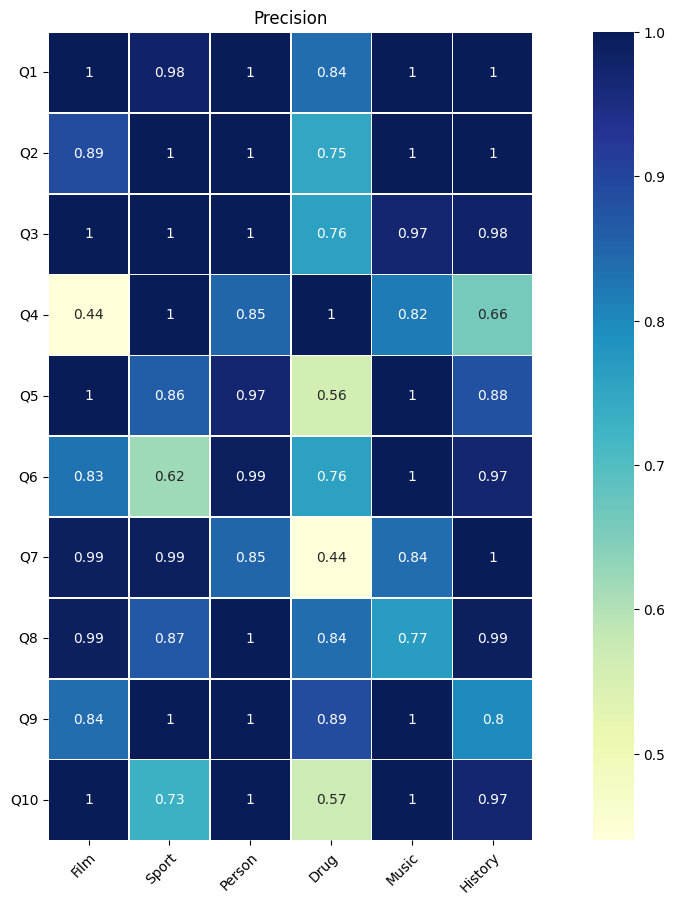

In [13]:
def precision(precision):
    precision = pd.read_csv("Precision-Recall/Precision.csv", index_col=0)
    cmap = sns.cm.rocket_r
    ax = sns.heatmap(precision, cmap = 'YlGnBu', linewidth=0.5, annot=precision)
    im = ax.imshow(precision)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0,
             rotation_mode="anchor")
    fig = plt.gcf()
    fig.set_size_inches(15.5, 10.5)
    plt.title('Precision')
    plt.savefig('Precision-Recall/Precision.png', dpi=100)
    plt.show()   
precision(precision)

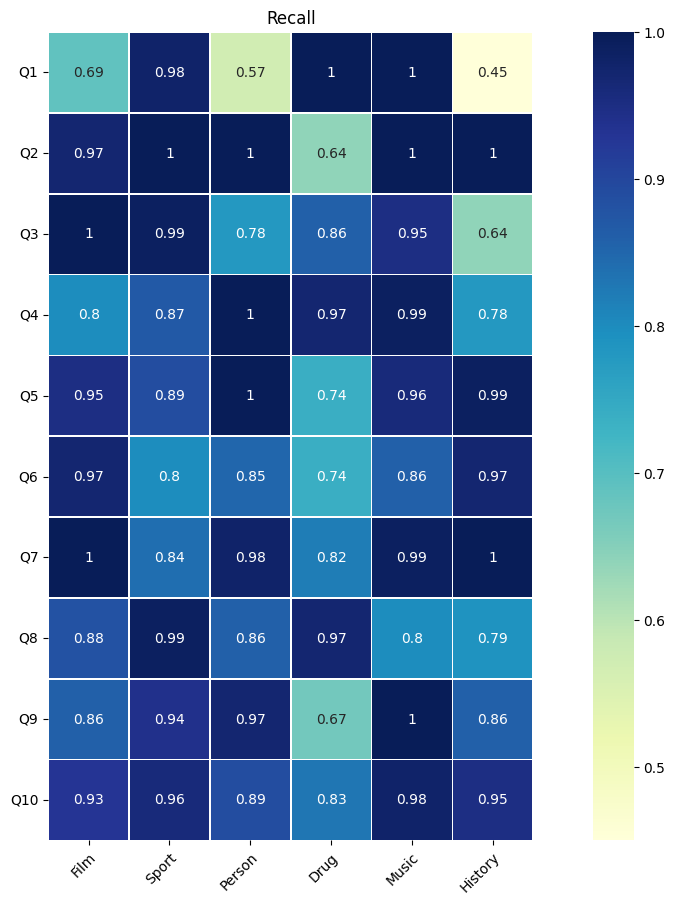

In [14]:
def recall(recall):
    recall = pd.read_csv("Precision-Recall/Recall.csv", index_col=0)
    cmap = sns.cm.rocket_r
    ax = sns.heatmap(recall, cmap = 'YlGnBu', linewidth=0.5, annot=recall)
    im = ax.imshow(recall)


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.setp(ax.get_yticklabels(), rotation=0,
             rotation_mode="anchor")
    # ax.set_title("")

    fig = plt.gcf()
    fig.set_size_inches(15.5, 10.5)

    plt.title('Recall')
    plt.savefig('Precision-Recall/Recall.png', dpi=100)
    plt.show()
    
recall(recall)